# Lecture 6: Support Vector Machines

The scikit-learn documentation has a nice write-up of support vector machines [here](http://scikit-learn.org/stable/modules/svm.html).  There are three different implementations: [SVC](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC), which is the main one that we'll use, [NuSVC](http://scikit-learn.org/stable/modules/generated/sklearn.svm.NuSVC.html#sklearn.svm.NuSVC), which is a slightly different formulation, and [LinearSVC](http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC), which only supports linear kernels but is faster on large datasets.  

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# this is a new import
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, roc_auc_score
from sklearn.cross_validation import train_test_split
from sklearn import datasets
import seaborn as sns
from sklearn.grid_search import GridSearchCV

We're going to work with the by-now-nauseatingly-familiar iris dataset.

In [4]:
iris = datasets.load_iris()

X = iris.data
y = iris.target

In [5]:
print(iris.DESCR)

Iris Plants Database

Notes
-----
Data Set Characteristics:
    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20  0.76     0.9565  (high!)
    ============== ==== ==== ======= ===== ====================

    :Missing Attribute Values: None
  

In [6]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

We'll build a binary model to predict species 2 vs species 3, using the first two features only, so that we can visualize it.

In [7]:
# Get the first two features for all observations where the species is 
# either species 2 (class '1' in the data) or species 3 (class '2' in the data)
X = X[y != 0, :2]

# Get the class labels for observations that either species 2 or 3
y = y[y != 0]

Next, let's create a train/test split.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9)

Recall from ISLR that the support vector machine takes a parameter $C$ that determines the amount of slack, or the maximum number of misclassified observations, allowed. In scklearn, $C$ has the opposite interpretation -larger values of $C$ mean there is *less* slack, while smaller values allow more slack.  In addition, while the linear kernel requires no additional parameters, other kernels typically do.  The *polynomial kernel*, which is defined as $K\left(x,x'\right) = \left(\gamma\langle x, x' \rangle + 1\right)^{d}$ in sklearn, takes two parameters ($\gamma$ and $d$).  The *radial kernel*, defined as $K\left(x,x'\right) = e^{-\gamma \sum_{j=1}^{p}\left(x_{j}-x'_{j}\right)^{2}}$ takes one ($\gamma$).

Let's now define a function that will train an SVM with a given kernel. The function will return the trained model, the test predictions, and the test distances from the hyperplane.


In [9]:
# Note that we are setting the linear kernel as the default
# in the event that no kernel is specified, and 
# we're passing the parameter gamma regardless of whether it's required
# (e.g., radial kernel) or not (e.g., linear kernel).  We can do this
# because the SVC function in Python ignores parameters that are not 
# used by the kernel passed to it.
def train_svm(kernel="linear", C=1.0, gamma=1.0, degree=4):

    svm = SVC(kernel=kernel, degree=degree, C=C, gamma=gamma) # Fixing polynomial degree at 4
    svm.fit(X_train, y_train) # Fitting the SVM

    # predict on the test set
    y_preds = svm.predict(X_test)
    # get the distances from the hyperplane, the sign of which
    # is the prediction above
    y_dists = svm.decision_function(X_test)
    
    return (svm, y_preds, y_dists)

Let's define a function that will take a trained SVM and plot the 2-dimensional decision function, along with the training and test points.

In [10]:
X

array([[ 7. ,  3.2],
       [ 6.4,  3.2],
       [ 6.9,  3.1],
       [ 5.5,  2.3],
       [ 6.5,  2.8],
       [ 5.7,  2.8],
       [ 6.3,  3.3],
       [ 4.9,  2.4],
       [ 6.6,  2.9],
       [ 5.2,  2.7],
       [ 5. ,  2. ],
       [ 5.9,  3. ],
       [ 6. ,  2.2],
       [ 6.1,  2.9],
       [ 5.6,  2.9],
       [ 6.7,  3.1],
       [ 5.6,  3. ],
       [ 5.8,  2.7],
       [ 6.2,  2.2],
       [ 5.6,  2.5],
       [ 5.9,  3.2],
       [ 6.1,  2.8],
       [ 6.3,  2.5],
       [ 6.1,  2.8],
       [ 6.4,  2.9],
       [ 6.6,  3. ],
       [ 6.8,  2.8],
       [ 6.7,  3. ],
       [ 6. ,  2.9],
       [ 5.7,  2.6],
       [ 5.5,  2.4],
       [ 5.5,  2.4],
       [ 5.8,  2.7],
       [ 6. ,  2.7],
       [ 5.4,  3. ],
       [ 6. ,  3.4],
       [ 6.7,  3.1],
       [ 6.3,  2.3],
       [ 5.6,  3. ],
       [ 5.5,  2.5],
       [ 5.5,  2.6],
       [ 6.1,  3. ],
       [ 5.8,  2.6],
       [ 5. ,  2.3],
       [ 5.6,  2.7],
       [ 5.7,  3. ],
       [ 5.7,  2.9],
       [ 6.2,

In [11]:
def plot_svm(svm, X, X_test):

    # plot all of the data points
    plt.scatter(X[:, 0], X[:, 1], c=y, zorder=10, cmap=plt.cm.Paired)
    
    # put an extra circle on top of the test points
    plt.scatter(X_test[:, 0], X_test[:, 1], s=80, facecolors='none', zorder=10)

    # step size of the mesh
    h = 0.01
    
    # range of the mesh
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    z = svm.decision_function(np.column_stack((xx.ravel(), yy.ravel())))

    z = z.reshape(xx.shape)
    plt.pcolormesh(xx, yy, z > 0, cmap=plt.cm.Paired)
    
    # this will plot the contour lines of the decision function
    plt.contour(xx, yy, z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'],
    levels=[-.5, 0, .5])

    plt.show()

First we'll train a linear SVM.

In [12]:
svm_linear, y_preds_linear, y_dists_linear = train_svm("linear", C=1.0)

In [13]:
y_preds_linear

array([2, 1, 1, 2, 2, 1, 2, 2, 2, 2])

In [14]:
y_dists_linear

array([ 0.08667479, -1.40667065, -1.40667065,  0.66667933,  2.34002932,
       -0.31999339,  0.87334751,  0.95334751,  0.29334297,  0.83334751])

We can see how many support vectors there are.  That is, how many points are on or inside of the margin.  This will return the number of support vectors of each class:

In [15]:
svm_linear.n_support_

array([32, 31])

In [16]:
# indices of the support vectors
svm_linear.support_

array([ 1,  5,  7,  8, 10, 17, 19, 20, 22, 29, 31, 34, 38, 41, 43, 45, 46,
       54, 56, 58, 64, 65, 66, 69, 70, 75, 80, 81, 82, 83, 85, 89,  0,  2,
        3,  6, 12, 16, 18, 21, 24, 26, 28, 30, 33, 35, 36, 37, 39, 40, 44,
       47, 49, 53, 62, 67, 68, 71, 72, 76, 79, 84, 86])

In [17]:
# the vectors themselves
svm_linear.support_vectors_[0:5]

array([[ 6. ,  3.4],
       [ 6.3,  2.5],
       [ 5.7,  3. ],
       [ 6.7,  3. ],
       [ 6.1,  3. ]])

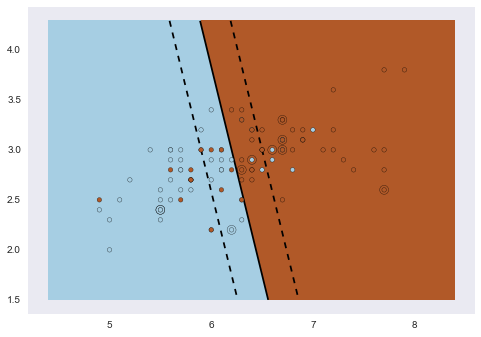

In [18]:
svm_linear, y_preds_linear, y_dists_linear = train_svm("linear", C=1.0)
plot_svm(svm_linear, X, X_test)

Let's try decreasing the C parameter, which is the opposite of how ISLR defines it.  In ISLR, C is the budget for how many points are allowed to violate the margin.  So larger C means more violations are allowed.  In scikit-learn, it's the opposite -smaller values of $C$ allow for more violations.

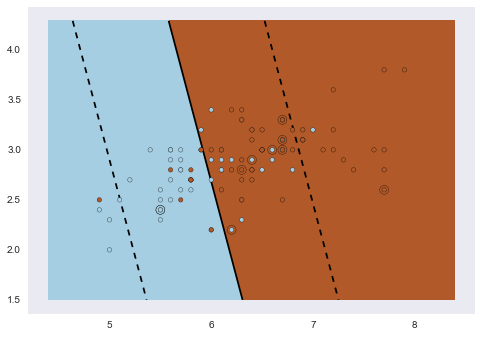

In [19]:
# C is the inverse of how ISLR defines it
svm_linear, y_preds_linear, y_dists_linear = train_svm("linear", C=0.02)
plot_svm(svm_linear, X, X_test)

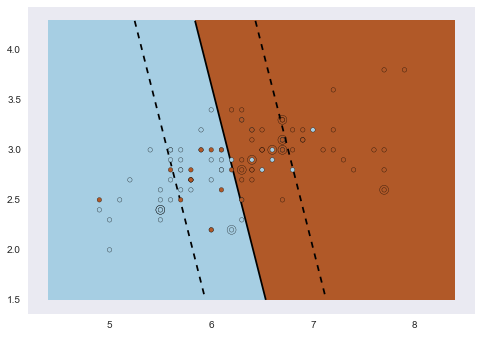

In [20]:
svm_linear, y_preds_linear, y_dists_linear = train_svm("linear", C=0.05)
plot_svm(svm_linear, X, X_test)

In [21]:
param_grid = {"C":[0.001, 0.01, 0.1, 1, 10, 100, 1000],
             'gamma': [0.01, 1, 1.0]}

svm = SVC(kernel="linear")
cv = GridSearchCV(svm, param_grid, cv=5, n_jobs=4, refit=True)
cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'gamma': [0.01, 1, 1.0], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [22]:
X_train[:,1]


array([ 3.4,  3.4,  3. ,  2.7,  3.1,  2.5,  2.5,  3. ,  3. ,  3. ,  3. ,
        3.2,  3. ,  2.5,  2.5,  2.9,  3.1,  2.8,  2.8,  3.2,  2.8,  2.7,
        2.6,  3.2,  2.2,  2.9,  3.1,  3.6,  2.8,  3.1,  2.7,  3. ,  2.7,
        2.5,  3. ,  3.3,  2.9,  3.2,  2.9,  3.2,  3.4,  2.7,  2.4,  3.2,
        3. ,  2.6,  3.3,  2.8,  3.1,  2.5,  2.5,  2.8,  3.8,  2.8,  2.8,
        2.3,  2.7,  3. ,  2.8,  2.6,  3.2,  2.3,  2.6,  3. ,  2.9,  2.2,
        2.9,  2.5,  3. ,  3. ,  2.9,  2.7,  3. ,  2.7,  3. ,  2.9,  2.8,
        2.8,  3. ,  3. ,  2.8,  2.8,  2.7,  3.1,  3. ,  2.3,  3.3,  3.8,
        2. ,  3.2])

In [23]:
y_train

array([2, 1, 2, 2, 2, 1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 2, 2, 1, 2, 1, 1, 2, 1,
       2, 2, 1, 2, 2, 2, 1, 2, 1, 1, 2, 1, 2, 2, 2, 1, 2, 2, 1, 1, 1, 2, 1,
       1, 2, 2, 2, 1, 2, 2, 2, 1, 1, 1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 2, 2,
       1, 1, 2, 2, 1, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1])

In [24]:
cv.grid_scores_

[mean: 0.51111, std: 0.01369, params: {'gamma': 0.01, 'C': 0.001},
 mean: 0.51111, std: 0.01369, params: {'gamma': 1, 'C': 0.001},
 mean: 0.51111, std: 0.01369, params: {'gamma': 1.0, 'C': 0.001},
 mean: 0.51111, std: 0.01369, params: {'gamma': 0.01, 'C': 0.01},
 mean: 0.51111, std: 0.01369, params: {'gamma': 1, 'C': 0.01},
 mean: 0.51111, std: 0.01369, params: {'gamma': 1.0, 'C': 0.01},
 mean: 0.73333, std: 0.06259, params: {'gamma': 0.01, 'C': 0.1},
 mean: 0.73333, std: 0.06259, params: {'gamma': 1, 'C': 0.1},
 mean: 0.73333, std: 0.06259, params: {'gamma': 1.0, 'C': 0.1},
 mean: 0.74444, std: 0.05763, params: {'gamma': 0.01, 'C': 1},
 mean: 0.74444, std: 0.05763, params: {'gamma': 1, 'C': 1},
 mean: 0.74444, std: 0.05763, params: {'gamma': 1.0, 'C': 1},
 mean: 0.72222, std: 0.08511, params: {'gamma': 0.01, 'C': 10},
 mean: 0.72222, std: 0.08511, params: {'gamma': 1, 'C': 10},
 mean: 0.72222, std: 0.08511, params: {'gamma': 1.0, 'C': 10},
 mean: 0.72222, std: 0.08511, params: {'gamma

In [25]:
# This SVM has the best performance according to cross validation 
# (measured by classification accuracy)
cv.best_params_

{'C': 1, 'gamma': 0.01}

Let's fit an SVM with a polynomial kernel of degree 2:

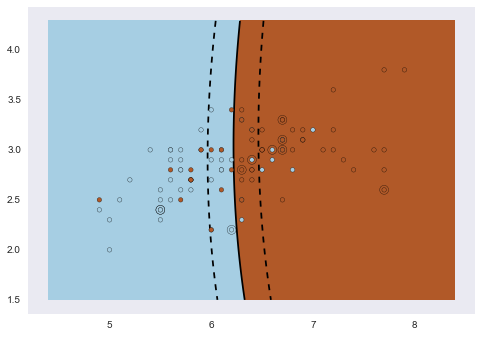

In [26]:
svm_poly, y_preds_poly, y_dists_poly = train_svm("poly", degree=2)
plot_svm(svm_poly, X, X_test)

Let's now fit an SVM with polynomial kernel of degree 2, but allow for more violations of the margin and boundary (smaller value of $C$)

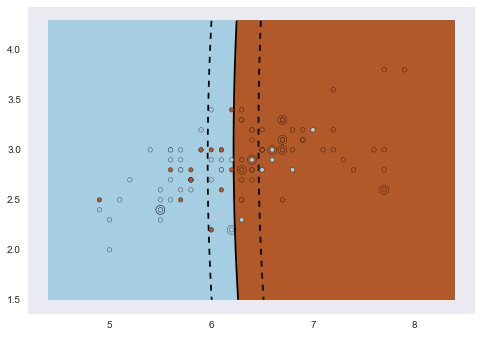

In [27]:
svm_poly, y_preds_poly, y_dists_poly = train_svm("poly", degree=2, C = 0.2)
plot_svm(svm_poly, X, X_test)

Let's fit an SVM with a polynomial kernel of degree 3:

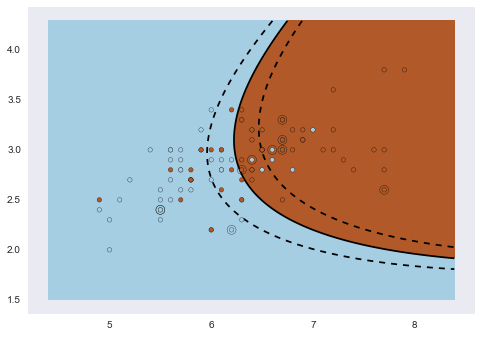

In [28]:
svm_poly, y_preds_poly, y_dists_poly = train_svm("poly", C=1.0, degree=3)
plot_svm(svm_poly, X, X_test)

Let's again fit an SVM with a polynomial kernel of degree 3, but allow for more violations (lower value of $C$)

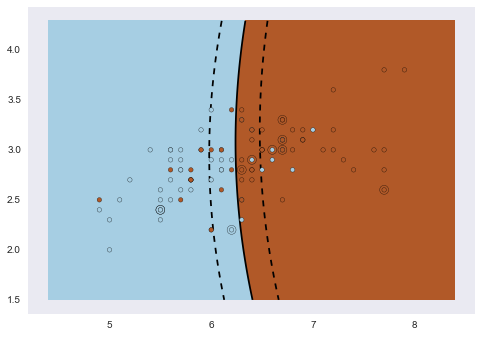

In [29]:
svm_poly, y_preds_poly, y_dists_poly = train_svm("poly", C=0.01, degree=3)
plot_svm(svm_poly, X, X_test)

Let's fit an SVM with an RBF kernel:

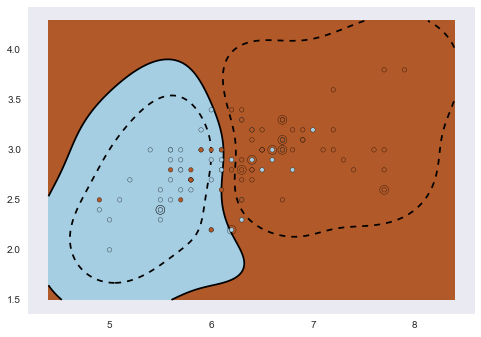

In [30]:
svm_rbf, y_preds_rbf, y_dists_rbf = train_svm("rbf", C=1.0, gamma=3)
plot_svm(svm_rbf, X, X_test)

Increasing the parameter of the RBF kernel makes us look at more and more local points, increasing the variance:

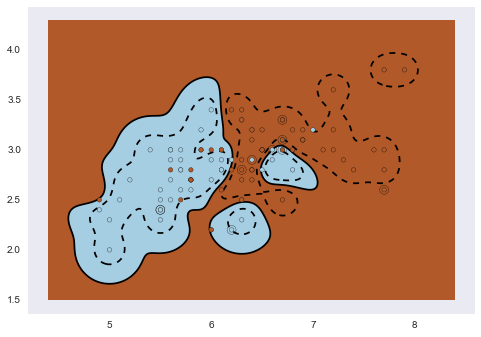

In [31]:
svm_rbf, y_preds_rbf, y_dists_rbf = train_svm("rbf", C=1.0, gamma=30)
plot_svm(svm_rbf, X, X_test)

## Text Classification

SVM's are quite ofen used in text classification problems.  Here, we're going to work through an example (a modified version of [this](http://scikit-learn.org/stable/auto_examples/text/document_classification_20newsgroups.html)) using the 20 newsgroups dataset. This dataset consists of samples of text from 20 different message boards (or newsgroups).  Each document is therefore classified as belonging to 1 of the 20 possible newsgroups.  See https://archive.ics.uci.edu/ml/datasets/Twenty+Newsgroups for more detail.

In [32]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer

First we'll load the data.  We'll load a training set first, then a test set.  Python's ```fetch_20newsgroups``` function does this for us.  The ```remove``` argument makes sure to remove metadata from each post like the header, footer, and quotes (instances where a message seems to quote another message). http://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html

In [33]:
data_train = fetch_20newsgroups(subset='train', categories=None,
                                shuffle=True, random_state=42,
                                remove=('headers', 'footers', 'quotes'))

data_test = fetch_20newsgroups(subset='test', categories=None,
                               shuffle=True, random_state=42,
                               remove=('headers', 'footers', 'quotes'))

In [34]:
data_train.keys()

dict_keys(['data', 'DESCR', 'target_names', 'description', 'filenames', 'target'])

In [35]:
# Let's check how many observations we have
len(data_train.data)

11314

In [36]:
#The data has postings from one of 20 "newsgroup" types.
data_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

The first training post comes from the "rec.autos" newsgroup:

In [37]:
# data_train.target[0] is the label of the first article, stored as a number.
# This value can be used to index into the target_names list, in order to match the
# messages label to its newsgroup.
data_train.target_names[data_train.target[0]]

'rec.autos'

And has the following contents:

In [38]:
print(data_train.data[0])

I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.


Let's make a binary target variable to predict whether a given post is in the "sci.space" newsgroup:

In [39]:
space_target = (data_train.target==14).astype("int")
space_target_test = (data_test.target==14).astype("int")

One way to turn a blob of text into features or predictors (to "vectorize" it) is to simply count up the number of times each word appears.  We'll use the ```CountVectorizer``` function provided in Python to do this for us.  However, we'll first need to remove common words that convey no meaning (like 'the', 'an', 'a', etc.).  These words are called *stop words*, and most packages that deal with text data have a list of them built in.  Therefore, we just need to tell ```CountVectorizer``` which language we're using, so it removes the appropriate stop words.

In [40]:
vectorizer = CountVectorizer(stop_words='english')
X_train = vectorizer.fit_transform(data_train.data) # Apply the vectorizer to the training data
X_test = vectorizer.transform(data_test.data) # Apply the vectorizer to the test data

The features are the number of times each word in the "vocabulary" appears in a given post.  Note that, by far, most words won't show up in most posts, so the matrix of predcitors is very "sparse".

In [41]:
# Check how many words are in the vocabulary for our documents
len(vectorizer.vocabulary_)

101323

In [42]:
# We see that our training set now has one obesrvaton per original training article,
# and one column per word in the vocabulary built up by the vectorizer
X_train.shape

(11314, 101323)

In [43]:
# The same is true for the test data
X_test.shape

(7532, 101323)

In [44]:
# We can also look at the vocabulary itself, and the column index each word corresponds to
# in the training and test data
vectorizer.vocabulary_

{'xvertext': 99032,
 '11110100': 2039,
 'inet_addr': 49685,
 'tinue': 88903,
 'newbies': 65486,
 'udc': 91025,
 'exabyte': 38340,
 'unfortunate': 91787,
 'aem': 17087,
 'sugrfx': 86009,
 'ns9w': 66562,
 'meinung': 60666,
 'meningitits': 60793,
 'zt58': 101157,
 'verity': 93804,
 'arenot': 19424,
 'note': 66350,
 'bridegroom': 24112,
 '71y': 11263,
 'kfj8': 53885,
 'nwh': 66787,
 'ftr': 41750,
 'gash': 42607,
 'ajwk': 17652,
 'lezgins': 56262,
 'suppressing': 86323,
 'latitude': 55628,
 '0r445': 1239,
 'departure': 32838,
 'clasps': 27691,
 'dcan': 31998,
 'moniter': 62811,
 'vmmt': 94395,
 'bql6cl': 23865,
 'geodesy': 43015,
 'shimizu': 82026,
 'poli': 72004,
 'openers': 68044,
 'venues': 93745,
 'xgetatomname': 98108,
 'dfio': 33313,
 'xcp73y': 97951,
 'prostitutes': 73486,
 'lykpikzsfk': 57866,
 'curbed': 30960,
 'stranded': 85404,
 'sexes': 81665,
 'scalable': 80490,
 'righty': 78220,
 'catabolism': 25962,
 '_0k': 14541,
 'tommorrow': 89204,
 'adb': 16787,
 'rm2': 78558,
 'bq4': 238

In [45]:
# As we mentioned, most words aren't used in most posts, so each row of the training set
# will be very sparse -very few entries will be bigger than zero.
# When Python sees his kind of sparsity, it uses a sparse matrix, which conceptually is just a matrix,
# but instead of storing every entry in the matrix, Python only stores the non-zero entries.  
X_train[0, :]

<1x101323 sparse matrix of type '<class 'numpy.int64'>'
	with 34 stored elements in Compressed Sparse Row format>

In [46]:
# However, if we want to see the first row of the training data, we can convert the sparse representation 
# to a dense representation (fills in all the empty positions with zeros)
X_train[0, :].todense()

matrix([[0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [47]:
# We can also find the non-zero entries for our first training observations
non_zeroes=np.where(X_train[0,:].todense())[1]
non_zeroes

array([ 9843, 11174, 16806, 23430, 24108, 24583, 25437, 25717, 31927,
       34741, 34742, 35902, 37208, 37256, 41875, 46691, 49801, 54494,
       55607, 57248, 57251, 59072, 62595, 73175, 76270, 77677, 80421,
       81451, 83209, 84051, 84313, 87914, 96880, 99609], dtype=int64)

Let's define a function that will take a list of indices and print the words from the vocabulary dictionary that correspond to those indices:

In [48]:
def print_words(index_list):
    for word, index in vectorizer.vocabulary_.iteritems(): # Check every word in the vocabulary
        if index in index_list: # If that word appears in our list for the given observation, write out the word
            print word

SyntaxError: Missing parentheses in call to 'print' (<ipython-input-48-0d3e3eb5cc4f>, line 4)

In [ ]:
print_words(non_zeroes)

Let's train a linear, penalized SVM:

In [ ]:
svm = LinearSVC(penalty='l2', C=1.0) # Setting penalty to 'l2' makes LinearSVC act like SVC
svm.fit(X_train, space_target)

One way to see what the SVM is doing is to look at the coefficients of each word, and to sort them from largest to smallest.  This will tell us which words are most associated with "space" in the posts:

In [ ]:
# svm.coef_.ravel() gives the list of coefficients from the SVM as a 1-dimensional array
# Apply np.argsort to that list orders the **indices** of that list in order of smallest coefficient to largest
# Then, the [-25:] tells Python to take the last 25 indices from that ordered list, which correspond to the indices
# of the 25 biggest coefficients.
top25 = np.argsort(svm.coef_.ravel())[-25:]
top25

In [ ]:
# Now, we'll show the 25 biggest coefficients
svm.coef_.ravel()[top25]

In [ ]:
# Finally, we can print the top 25 coefficients
print_words(top25)

[http://en.wikipedia.org/wiki/Wally_Schirra](http://en.wikipedia.org/wiki/Wally_Schirra)

Let's see how we do predicting whether or not a message is from the 'space' messge board for a test set:

In [ ]:
preds = svm.predict(X_test)

In [ ]:
pd.crosstab(index=space_target_test, columns=preds, rownames=['True'], colnames=['Predicted'])

Not bad.